Datos cargados desde archivo CSV
Datos: (49920, 4)
Datos después de preprocesamiento: (49752, 20)
Train: 34826, Validation: 7462, Test: 7464
X_train: (34635, 168, 20), y_train: (34635, 24)
X_val: (7271, 168, 20), y_val: (7271, 24)
X_test: (7273, 168, 20), y_test: (7273, 24)
Naive Model Evaluation:
MAE: 2.98, RMSE: 2.98, MAPE: 14.60%
Entrenando modelo ARIMA...


/home/bita/.pyenv/versions/3.9.18/envs/ts_weather/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/bita/.pyenv/versions/3.9.18/envs/ts_weather/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/bita/.pyenv/versions/3.9.18/envs/ts_weather/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


ARIMA Evaluation:
MAE: 2.45, RMSE: 2.45, MAPE: 11.89%
ARIMA failed: [Errno 2] No such file or directory: 'models/arima_temperature_model.pkl'
Entrenando modelo LSTM...


2025-09-20 23:04:28.568559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-20 23:04:28.569807: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bita/hadoop/lib/native:
2025-09-20 23:04:28.570124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bita/hadoop/lib/native:
2025-09-20 23:04:28.570303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or dir

Epoch 1/20
1083/1083 [==============================] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.1186

2025-09-20 23:08:44.620802: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 97722240 exceeds 10% of free system memory.


1083/1083 [==============================] - 266s 239ms/step - loss: 0.0302 - mean_absolute_error: 0.1186 - val_loss: 0.0061 - val_mean_absolute_error: 0.0613
Epoch 2/20
1083/1083 [==============================] - 265s 245ms/step - loss: 0.0074 - mean_absolute_error: 0.0657 - val_loss: 0.0048 - val_mean_absolute_error: 0.0534
Epoch 3/20
1083/1083 [==============================] - 263s 243ms/step - loss: 0.0065 - mean_absolute_error: 0.0616 - val_loss: 0.0050 - val_mean_absolute_error: 0.0561
Epoch 4/20
1083/1083 [==============================] - 228s 210ms/step - loss: 0.0063 - mean_absolute_error: 0.0602 - val_loss: 0.0046 - val_mean_absolute_error: 0.0526
Epoch 5/20
1083/1083 [==============================] - 226s 208ms/step - loss: 0.0062 - mean_absolute_error: 0.0598 - val_loss: 0.0042 - val_mean_absolute_error: 0.0498
Epoch 6/20
1083/1083 [==============================] - 233s 215ms/step - loss: 0.0061 - mean_absolute_error: 0.0593 - val_loss: 0.0046 - val_mean_absolute_error

2025-09-21 00:24:44.897838: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 97749120 exceeds 10% of free system memory.


228/228 [==============================] - 13s 51ms/step
LSTM Evaluation:
MAE: 0.04, RMSE: 0.06, MAPE: 12.70%


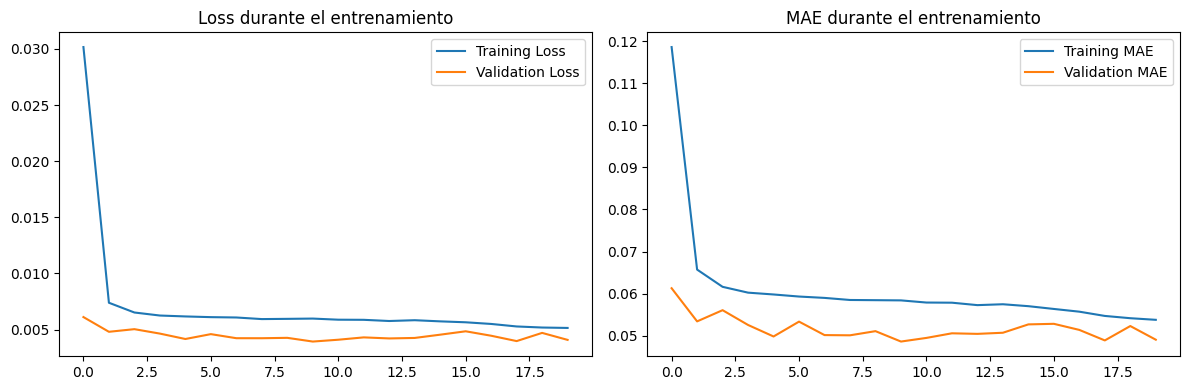

Entrenando modelo Transformer...


In [ ]:
# %% [markdown]
# # Predicción de Temperatura
# 
# Este notebook entrena y evalúa modelos para predecir temperatura.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Importar funciones del pipeline
from ts_weather_pipeline.api import fetch_open_meteo_archive
from ts_weather_pipeline.preprocessing import fill_and_resample, add_time_features, add_lags, add_fourier
from ts_weather_pipeline.baselines import naive_forecast, fit_var, fit_arima
from ts_weather_pipeline.deep_learning import make_supervised, build_lstm_model, build_transformer_encoder
from ts_weather_pipeline.evaluation import evaluate_multi_horizon
from ts_weather_pipeline.transformer import make_supervised_transformer

# Configuración
target = "temperature_2m"
plt.style.use('default')

# %%
# Cargar datos
try:
    df = pd.read_csv('../data/temperature_data.csv', index_col=0, parse_dates=True)
    print("Datos cargados desde archivo CSV")
except:
    print("Descargando datos...")
    df = fetch_open_meteo_archive(
        lat=-34.6037, 
        lon=-58.3816, 
        start_date="2020-01-01",
        end_date="2025-09-10",
        hourly_vars=["temperature_2m", "relativehumidity_2m", "windspeed_10m", "precipitation"]
    )
    df = fill_and_resample(df, freq="H")

print(f"Datos: {df.shape}")

# %%
# Añadir características
df = add_time_features(df)
df = add_lags(df, target, lags=(1, 24, 168))  # 1h, 24h, 1 semana
df = add_fourier(df, period_hours=24, n_harmonics=3)

# Eliminar valores nulos
df = df.dropna()
print(f"Datos después de preprocesamiento: {df.shape}")

# %%
# Dividir datos
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)
test_size = len(df) - train_size - val_size

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size+val_size]
test_df = df.iloc[train_size+val_size:]

print(f"Train: {train_size}, Validation: {val_size}, Test: {test_size}")

# %%
# Escalar datos
scaler = MinMaxScaler()
features = train_df.select_dtypes(include="number").columns.tolist()
scaler.fit(train_df[features])

train_scaled = pd.DataFrame(scaler.transform(train_df[features]), 
                           columns=features, index=train_df.index)
val_scaled = pd.DataFrame(scaler.transform(val_df[features]), 
                         columns=features, index=val_df.index)
test_scaled = pd.DataFrame(scaler.transform(test_df[features]), 
                          columns=features, index=test_df.index)

# Guardar scaler
joblib.dump(scaler, '../models/temperature_scaler.pkl')
with open('../models/temperature_features.json', 'w') as f:
    json.dump({"features": features, "target": target}, f)

# %%
# Preparar datos supervisados
input_width = 168  # 1 semana
output_width = 24  # 24 horas

X_train, y_train, _ = make_supervised(train_scaled, target, input_width, output_width)
X_val, y_val, _ = make_supervised(val_scaled, target, input_width, output_width)
X_test, y_test, _ = make_supervised(test_scaled, target, input_width, output_width)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# %%
# Modelo Naive (baseline)
naive_pred = naive_forecast(train_df[target], output_width)
naive_eval = evaluate_multi_horizon(test_df[target].values[:output_width], naive_pred)

print("Naive Model Evaluation:")
print(f"MAE: {naive_eval['mae']:.2f}, RMSE: {naive_eval['rmse']:.2f}, MAPE: {naive_eval['mape']:.2f}%")

# %%
# Modelo ARIMA
print("Entrenando modelo ARIMA...")
try:
    exog_feats = ["hour_sin", "hour_cos", "month_sin", "month_cos"]
    arima_res = fit_arima(train_df[target], exog=train_df[exog_feats])
    arima_fc = arima_res.get_forecast(steps=output_width, 
                                     exog=test_df[exog_feats].iloc[:output_width])
    
    arima_eval = evaluate_multi_horizon(test_df[target].iloc[:output_width].values, 
                                       arima_fc.predicted_mean.values)
    
    print("ARIMA Evaluation:")
    print(f"MAE: {arima_eval['mae']:.2f}, RMSE: {arima_eval['rmse']:.2f}, MAPE: {arima_eval['mape']:.2f}%")
    
    # Guardar modelo ARIMA
    joblib.dump(arima_res, '../models/arima_temperature_model.pkl')
    
except Exception as e:
    print(f"ARIMA failed: {e}")

# %%
# Modelo LSTM
print("Entrenando modelo LSTM...")
try:
    lstm_model = build_lstm_model(
        (input_width, len(features)), 
        output_width, 
        units=32,  # Reducido para ahorrar memoria
        lr=1e-3
    )
    
    history = lstm_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,  # Reducido para ahorrar tiempo
        batch_size=32,
        verbose=1
    )
    
    # Evaluar LSTM
    y_pred_lstm = lstm_model.predict(X_test, batch_size=32)
    lstm_eval = evaluate_multi_horizon(y_test, y_pred_lstm)
    
    print("LSTM Evaluation:")
    print(f"MAE: {lstm_eval['mae']:.2f}, RMSE: {lstm_eval['rmse']:.2f}, MAPE: {lstm_eval['mape']:.2f}%")
    
    # Guardar modelo LSTM
    lstm_model.save('../models/lstm_temperature_model.h5')
    
    # Graficar historial de entrenamiento
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss durante el entrenamiento')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title('MAE durante el entrenamiento')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"LSTM failed: {e}")

# %%
# Modelo Transformer
print("Entrenando modelo Transformer...")
try:
    # Preparar datos para Transformer
    X_train_tf, y_train_tf, _ = make_supervised_transformer(train_scaled, target, input_width, output_width)
    X_val_tf, y_val_tf, _ = make_supervised_transformer(val_scaled, target, input_width, output_width)
    X_test_tf, y_test_tf, _ = make_supervised_transformer(test_scaled, target, input_width, output_width)
    
    transformer_model = build_transformer_encoder(
        (input_width, len(features)),
        output_width,
        d_model=64,  # Reducido para ahorrar memoria
        num_heads=4,
        ff_dim=128,
        num_blocks=2,
        dropout=0.1,
        lr=1e-3
    )
    
    history_tf = transformer_model.fit(
        X_train_tf, y_train_tf,
        validation_data=(X_val_tf, y_val_tf),
        epochs=20,  # Reducido para ahorrar tiempo
        batch_size=32,
        verbose=1
    )
    
    # Evaluar Transformer
    y_pred_tf = transformer_model.predict(X_test_tf, batch_size=32)
    tf_eval = evaluate_multi_horizon(y_test_tf, y_pred_tf)
    
    print("Transformer Evaluation:")
    print(f"MAE: {tf_eval['mae']:.2f}, RMSE: {tf_eval['rmse']:.2f}, MAPE: {tf_eval['mape']:.2f}%")
    
    # Guardar modelo Transformer
    transformer_model.save('../models/transformer_temperature_model.h5')
    
    # Graficar historial de entrenamiento
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_tf.history['loss'], label='Training Loss')
    plt.plot(history_tf.history['val_loss'], label='Validation Loss')
    plt.title('Loss durante el entrenamiento')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history_tf.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history_tf.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title('MAE durante el entrenamiento')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Transformer failed: {e}")

# %%
# Comparar todos los modelos
results = {
    'Naive': naive_eval,
    'ARIMA': arima_eval if 'arima_eval' in locals() else None,
    'LSTM': lstm_eval if 'lstm_eval' in locals() else None,
    'Transformer': tf_eval if 'tf_eval' in locals() else None
}

# Crear gráfico de comparación
models = []
mae_scores = []
rmse_scores = []

for model_name, result in results.items():
    if result is not None:
        models.append(model_name)
        mae_scores.append(result['mae'])
        rmse_scores.append(result['rmse'])

plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, mae_scores, width, label='MAE')
plt.bar(x + width/2, rmse_scores, width, label='RMSE')

plt.xlabel('Modelos')
plt.ylabel('Error')
plt.title('Comparación de Modelos de Predicción de Temperatura')
plt.xticks(x, models)
plt.legend()
plt.tight_layout()
plt.show()

# %%
# Visualizar predicciones
plt.figure(figsize=(15, 10))

# Gráfico 1: Naive
plt.subplot(2, 2, 1)
plt.plot(test_df[target].values[:output_width], label='Real')
plt.plot(naive_pred, label='Naive')
plt.title('Predicción Naive')
plt.legend()

# Gráfico 2: ARIMA
if 'arima_fc' in locals():
    plt.subplot(2, 2, 2)
    plt.plot(test_df[target].values[:output_width], label='Real')
    plt.plot(arima_fc.predicted_mean.values, label='ARIMA')
    plt.title('Predicción ARIMA')
    plt.legend()

# Gráfico 3: LSTM
if 'y_pred_lstm' in locals():
    plt.subplot(2, 2, 3)
    plt.plot(y_test[0], label='Real')
    plt.plot(y_pred_lstm[0], label='LSTM')
    plt.title('Predicción LSTM')
    plt.legend()

# Gráfico 4: Transformer
if 'y_pred_tf' in locals():
    plt.subplot(2, 2, 4)
    plt.plot(y_test_tf[0], label='Real')
    plt.plot(y_pred_tf[0], label='Transformer')
    plt.title('Predicción Transformer')
    plt.legend()

plt.tight_layout()
plt.show()

# %%
# Guardar resultados de evaluación
evaluation_results = {
    'naive': naive_eval,
    'arima': arima_eval if 'arima_eval' in locals() else None,
    'lstm': lstm_eval if 'lstm_eval' in locals() else None,
    'transformer': tf_eval if 'tf_eval' in locals() else None
}

with open('../models/temperature_evaluation_results.json', 'w') as f:
    json.dump(evaluation_results, f, indent=4)

print("Resultados de evaluación guardados en models/temperature_evaluation_results.json")